In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
%matplotlib inline

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected=True)

C:\Users\eldiy\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

In [3]:
def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [4]:
dataset=pd.read_csv('hour_online.csv', parse_dates=['Time'], index_col='Time')
dataset.head()

,Users
Time,
2017-01-01 00:00:00,34002
2017-01-01 01:00:00,37947
2017-01-01 02:00:00,41517
2017-01-01 03:00:00,44476
2017-01-01 04:00:00,46234


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2625 entries, 2017-01-01 00:00:00 to 2017-04-20 09:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Users   2625 non-null   int64
dtypes: int64(1)
memory usage: 41.0 KB


In [6]:
plotly_df(dataset, title='Online Users')

In [7]:
def moving_average(series,n):
    return np.average(series[-n:])

moving_average(dataset.Users,24)

29858.333333333332

In [9]:
dataset.Users.rolling(24).mean().tail(10)

Time
2017-04-20 00:00:00    30470.916667
2017-04-20 01:00:00    30434.500000
2017-04-20 02:00:00    30394.166667
2017-04-20 03:00:00    30341.000000
2017-04-20 04:00:00    30259.541667
2017-04-20 05:00:00    30136.166667
2017-04-20 06:00:00    30058.000000
2017-04-20 07:00:00    29993.583333
2017-04-20 08:00:00    29928.000000
2017-04-20 09:00:00    29858.333333
Name: Users, dtype: float64

In [10]:
def plotMovingAverage(series, n, plot_bounds=False):
    
    """
    series - dataframe with timeseries
    n - rolling window size 
    plot_bounds: bool - whether to draw confidence interval
    """
    
    rolling_mean = series.rolling(window=n).mean()
        
    fig, ax = plt.subplots(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    if plot_bounds:
        rolling_std =  series.rolling(window=n).std()
        upper_bound = rolling_mean+1.96*rolling_std
        lower_bound = rolling_mean-1.96*rolling_std
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'));
    plt.xticks(rotation=45)

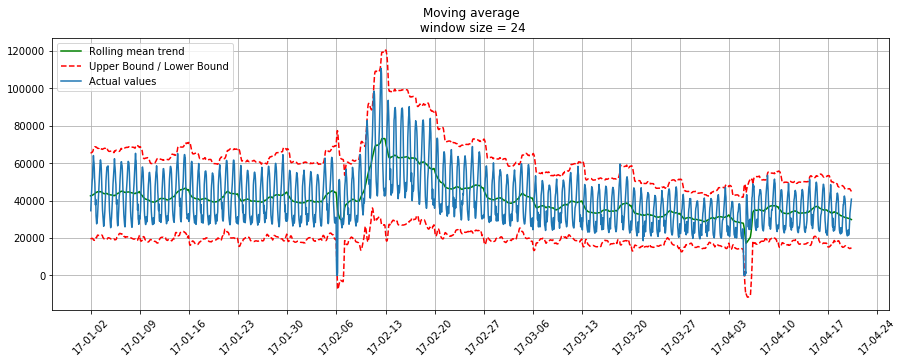

In [11]:
plotMovingAverage(dataset,24, plot_bounds=True)

In [12]:
def weighted_average(series,weights):
    results=0.0
    for n in range(len(weights)):
        results+=series[-n-1]*weights[n]
    return results

In [13]:
weighted_average(dataset.Users,[0.6,0.2,0.1,0.07,0.03])

39907.43

In [14]:
def exponential_smoothing(series,alpha):
    results=[series[0]]
    for n in range(1,len(series)):
        results.append(alpha*series[n]+(1-alpha)*results[n-1])
    return results

In [16]:
exponential_smoothing(dataset.Users,0.1);

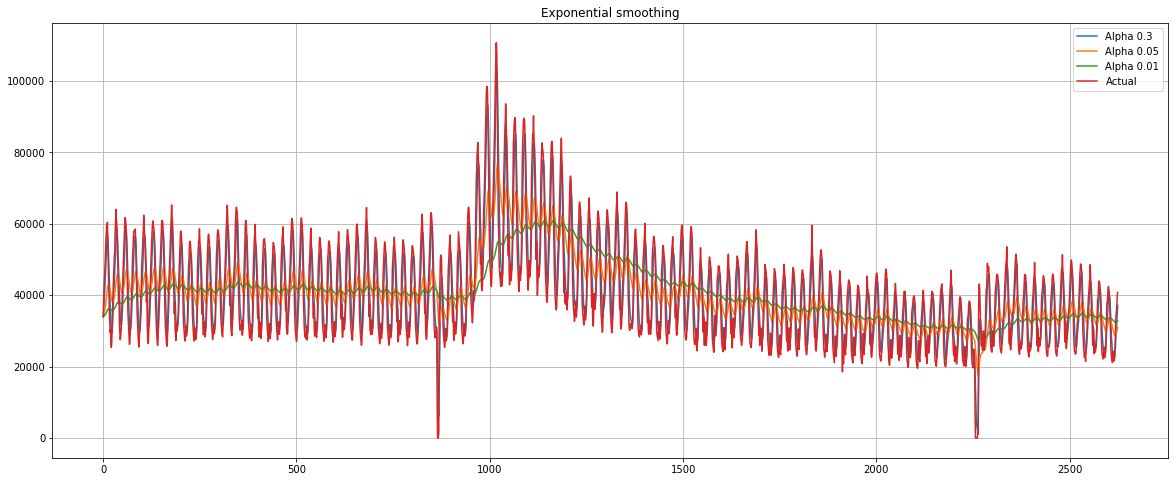

In [17]:
plt.figure(figsize=(20,8))
for alpha in [0.3,0.05,0.01]:
    plt.plot(exponential_smoothing(dataset.Users,alpha),label=f'Alpha {alpha}')
plt.plot(dataset.Users.values,label='Actual')
plt.legend(loc='best')
plt.title('Exponential smoothing')
plt.grid(True)
plt.show()

In [18]:
dataset['Exponential_smoothing']=exponential_smoothing(dataset.Users,0.05)
plotly_df(dataset, 'Exponential Smoothing')

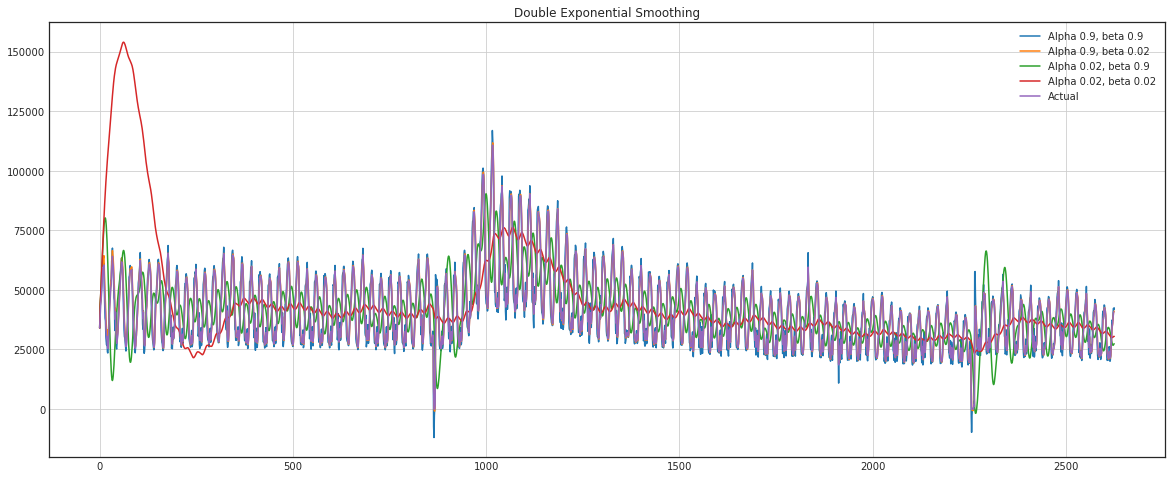

In [20]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): 
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result


with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]: # specify the values you want to test
        for beta in [0.9, 0.02]:  # specify the values you want to test
            plt.plot(double_exponential_smoothing(dataset.Users, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(dataset.Users.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [21]:
class HoltWinters:
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        seasonals = self.initial_seasonal_components()
        for i in range(len(self.series)+self.n_preds):
            if i == 0: 
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                self.PredictedDeviation.append(0)
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
            if i >= len(self.series): 
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])
        

In [22]:
from sklearn.model_selection import TimeSeriesSplit
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [50]:
from sklearn.metrics import mean_squared_error
data=dataset.Users[:-500] #last 500 for test

x=[0.5,0.1,0.1] #initial parameters. Depending on them your final parameters can make the model fit differently. We will discuss it later
   
opt=minimize(timeseriesCVscore, x0=x, 
             args=(data,mean_squared_error), method='TNC', bounds=((0,1),(0,1),(0,1))) 
#minimize the errors with limitations on the parameters (alpha, beta, gamma) to be within (0,1) range

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final,beta_final,gamma_final)

0.2910435320494809 0.002094534570617257 1.0


In [51]:
model=HoltWinters(data, slen=24, alpha=alpha_final, beta=beta_final, gamma=gamma_final,
                 n_preds=50, scaling_factor=3)
model.triple_exponential_smoothing()

In [52]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    def mean_absolute_percentage_error(y_true, y_pred): 
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

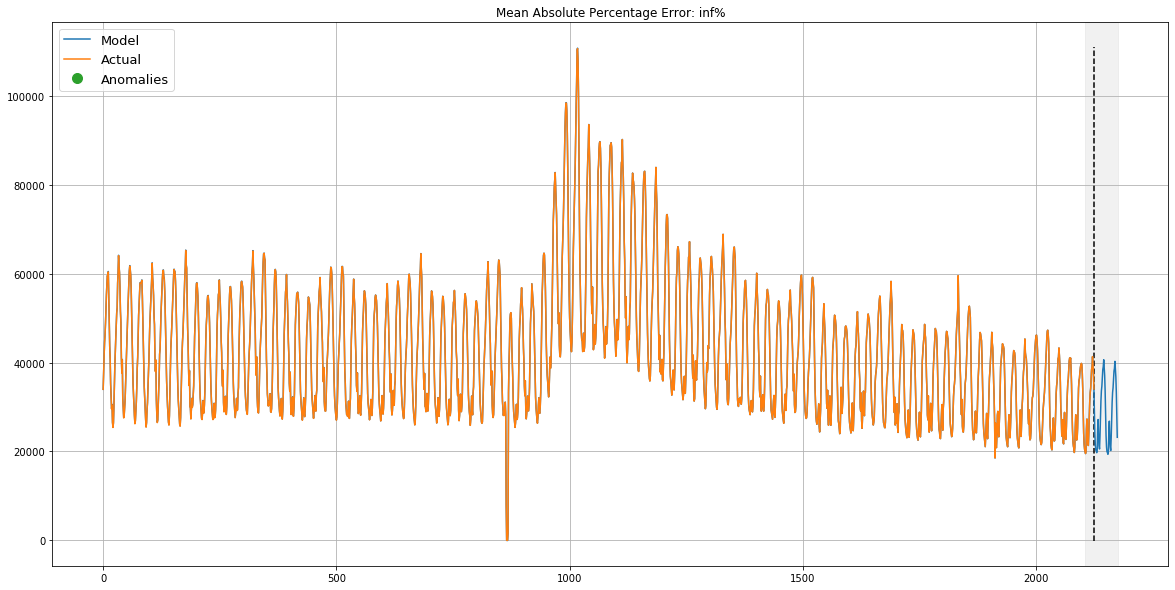

In [53]:
plotHoltWinters(dataset.Users[:-500],plot_intervals=False, plot_anomalies=True)

## Works well now. Fitted properly and predictions are fine

# Stationarity discussion

In [54]:
dataset.reset_index(inplace=True)
full_idx=pd.date_range(start=dataset.Time.min(), end=dataset.Time.max(), freq='H')
dataset.index=full_idx[:-1]
dataset=dataset.Users

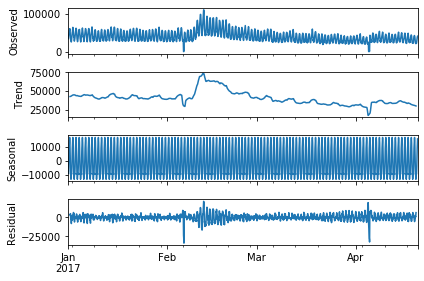

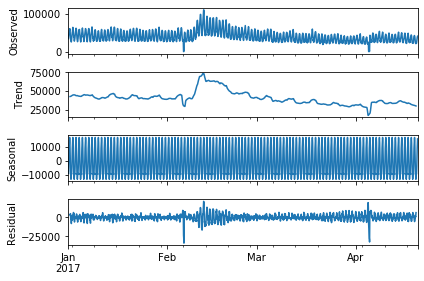

In [55]:
smt.seasonal_decompose(dataset).plot()

In [56]:
sdd=smt.seasonal_decompose(dataset)

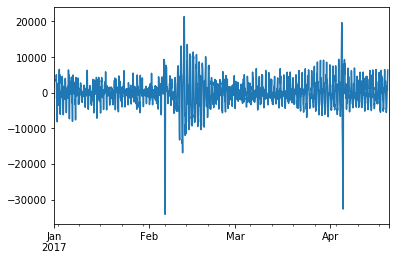

In [57]:
sdd.resid.plot()

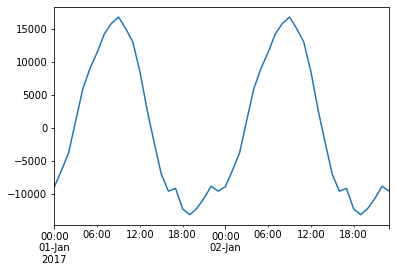

In [58]:
sdd.seasonal[:48].plot()

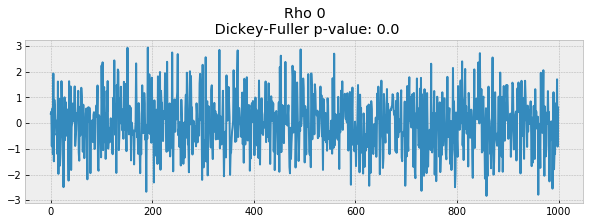

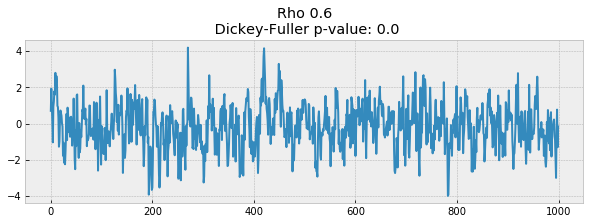

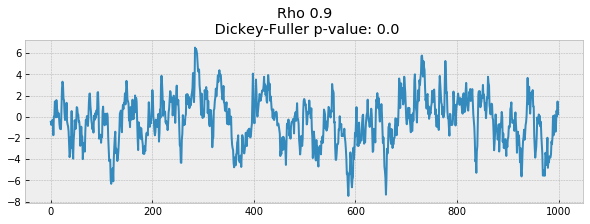

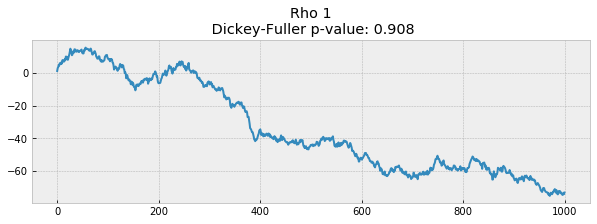

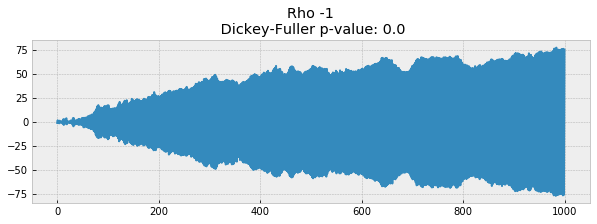

In [59]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1, -1]:
    plotProcess(rho=rho)

In [60]:
temp=pd.read_csv(r'C:\Users\eldiy\Downloads/Temp.csv',skiprows=1, sep=';',decimal=b',')

In [61]:
temp.head()

,YearNum,MonthCode,MoyenneDeRR,MoyenneDeTM
0,2010,1,50.460268,1.182103
1,2010,2,71.349446,3.696619
2,2010,3,55.103235,6.820855
3,2010,4,22.837806,10.801815
4,2010,5,65.447538,12.334801


In [62]:
temp['period']=temp.index+1

In [63]:
temp.drop('YearNum',axis=1,inplace=True)

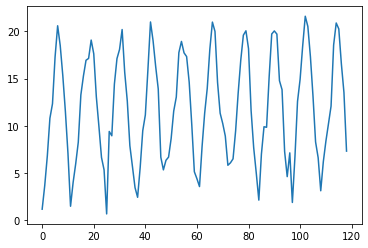

In [64]:
temp.MoyenneDeTM.plot()

In [65]:
X=pd.get_dummies(data=temp, columns=['MonthCode'], drop_first=True)

In [66]:
X.drop(['MoyenneDeTM','MoyenneDeRR'],axis=1, inplace=True)

In [67]:
y=temp.MoyenneDeTM

In [68]:
sm.OLS(y,sm.add_constant(X.drop(['MonthCode_2','MonthCode_12'],axis=1))).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            MoyenneDeTM   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     165.8
Date:                Thu, 13 Feb 2020   Prob (F-statistic):           9.75e-61
Time:                        17:56:05   Log-Likelihood:                -209.37
No. Observations:                 119   AIC:                             440.7
Df Residuals:                     108   BIC:                             471.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.1523      0.354     11.717      0.000       3.450       4.855
period           0.0099      0.004      2.512      0.013       0.002       0.018
MonthCode_3      3.0902      0.541      5.711      0.000       2.018       4.163
MonthCode_4      6.0271      0.541     11.139      0.000       4.955       7.100
MonthCode_5      8.8519      0.541     16.358      0.000       7.779       9.925
MonthCode_6     12.9335      0.541     23.898      0.000      11.861      14.006
MonthCode_7     15.1240      0.541     27.940      0.000      14.051      16.197
MonthCode_8     14.7333      0.541     27.211      0.000      13.660      15.806
MonthCode_9     11.5845      0.542     21.389      0.000      10.511      12.658
MonthCode_10     8.1318      0.542     15.009      0.000       7.058       9.206
MonthCode_11     3.4632      0.542      6.390      0.000       2.389       4.538
==============================================================================
Omnibus:                        0.442   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.802   Jarque-Bera (JB):                0.492
Skew:                          -0.142   Prob(JB):                        0.782
Kurtosis:                       2.863   Cond. No.                         499.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Dickey Fuller: p=%f" % sm.tsa.stattools.adfuller(y)[1])


        plt.tight_layout()
    return 

Dickey Fuller: p=0.190189


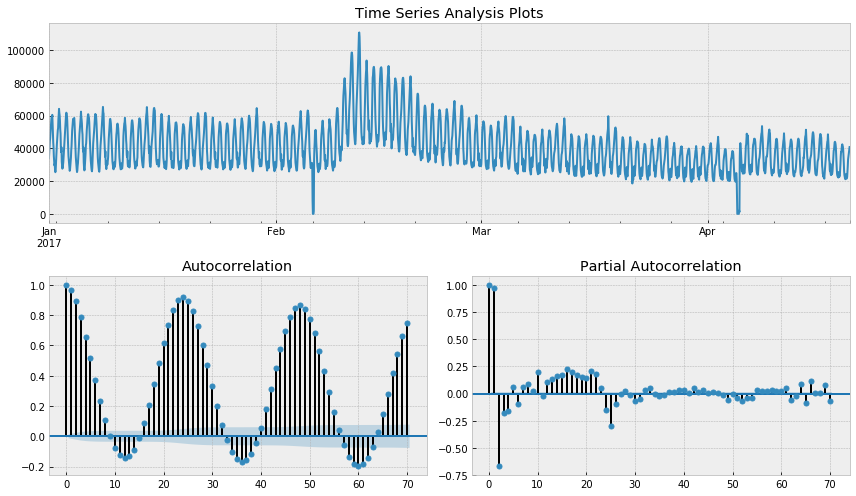

In [70]:
tsplot(dataset,lags=70)

In [71]:
data=dataset.copy()
data=pd.DataFrame(data)
data['User_season']=data.Users-data.Users.shift(24*7)

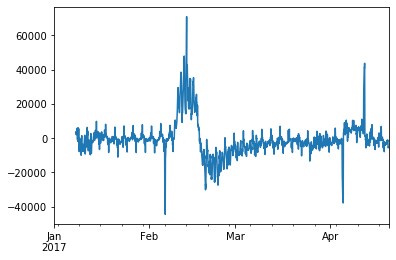

In [72]:
data.User_season.plot()

In [73]:
data['User_season_day']=data.User_season-data.User_season.shift(24)

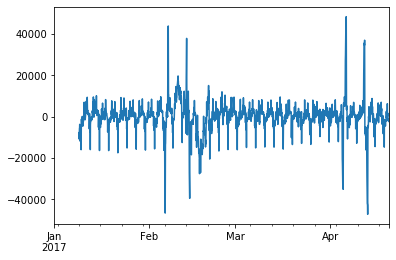

In [74]:
data.User_season_day.plot()

Dickey Fuller: p=0.000000


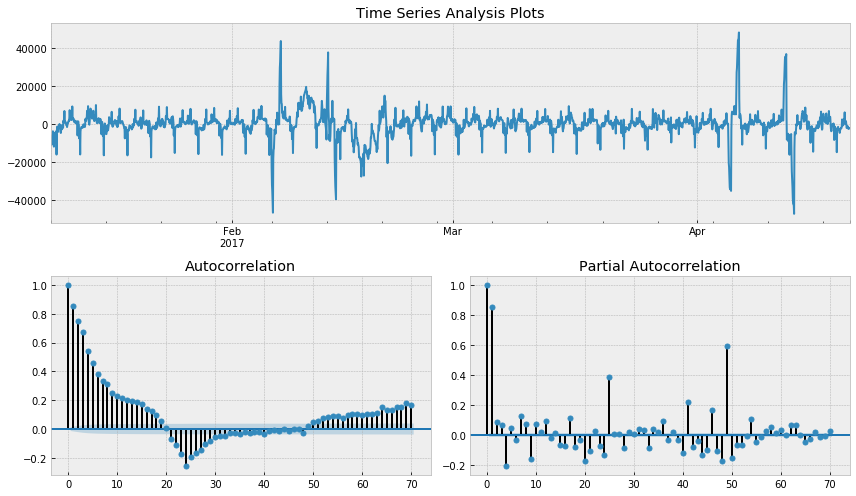

In [75]:
tsplot(data.User_season_day[24*8:],lags=70)

Dickey Fuller: p=0.000000


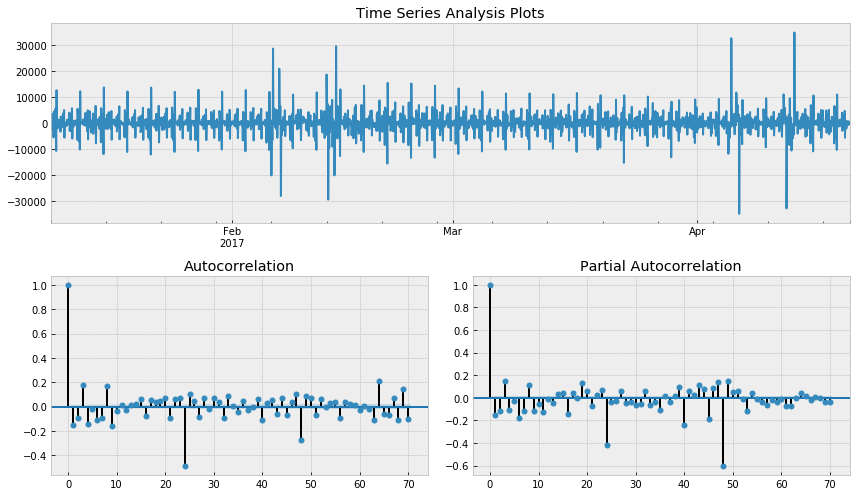

In [76]:
data['last_shift']=data.User_season_day-data.User_season_day.shift(1)
tsplot(data.last_shift[24*8+1:],lags=70)

In [77]:
ps=range(0,6)
qs=range(0,6)
d=1

In [78]:
from itertools import product
parameters=product(ps,qs)

In [79]:
results=[]
best_aic=np.inf
for param in parameters:
    try:
        model_arima=smt.ARIMA(dataset, order=(param[0],d,param[1])).fit()
    except:
        continue
    aic=model_arima.aic
    if aic<best_aic:
        best_model=model_arima
        besi_aic=aic
        best_param=param
    results.append([param,model_arima.aic])

In [80]:
result_table=pd.DataFrame(results,columns=['parameters','aic'])
result_table.sort_values(by='aic',ascending=True).head()

,parameters,aic
24,"(4, 5)",48182.633035
28,"(5, 5)",48183.473186
27,"(5, 4)",48271.270231
23,"(4, 4)",48296.036549
26,"(5, 3)",48323.965520


In [81]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Users   No. Observations:                 2624
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -24079.737
Method:                       css-mle   S.D. of innovations           2334.341
Date:                Thu, 13 Feb 2020   AIC                          48183.473
Time:                        17:59:26   BIC                          48253.943
Sample:                    01-01-2017   HQIC                         48208.994
                         - 04-20-2017                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.4465     24.496      0.100      0.920     -45.564      50.457
ar.L1.D.Users     0.4079        nan        nan        nan         nan         nan
ar.L2.D.Users     0.7758        nan        nan        nan         nan         nan
ar.L3.D.Users     0.5952        nan        nan        nan         nan         nan
ar.L4.D.Users    -0.9349        nan        nan        nan         nan         nan
ar.L5.D.Users    -0.0957        nan        nan        nan         nan         nan
ma.L1.D.Users    -0.1055      0.017     -6.332      0.000      -0.138      -0.073
ma.L2.D.Users    -0.9198      0.011    -81.124      0.000      -0.942      -0.898
ma.L3.D.Users    -0.8689      0.014    -61.330      0.000      -0.897      -0.841
ma.L4.D.Users     0.6944      0.012     58.871      0.000       0.671       0.718
ma.L5.D.Users     0.3349      0.017     19.854      0.000       0.302       0.368
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.7070           -0.7073j            1.0001           -0.3750
AR.2           -0.7070           +0.7073j            1.0001            0.3750
AR.3            0.9730           -0.2597j            1.0071           -0.0415
AR.4            0.9730           +0.2597j            1.0071            0.0415
AR.5          -10.3041           -0.0000j           10.3041           -0.5000
MA.1            1.0319           -0.1752j            1.0466           -0.0268
MA.2            1.0319           +0.1752j            1.0466            0.0268
MA.3           -0.7059           -0.7084j            1.0001           -0.3747
MA.4           -0.7059           +0.7084j            1.0001            0.3747
MA.5           -2.7257           -0.0000j            2.7257           -0.5000
-----------------------------------------------------------------------------
"""